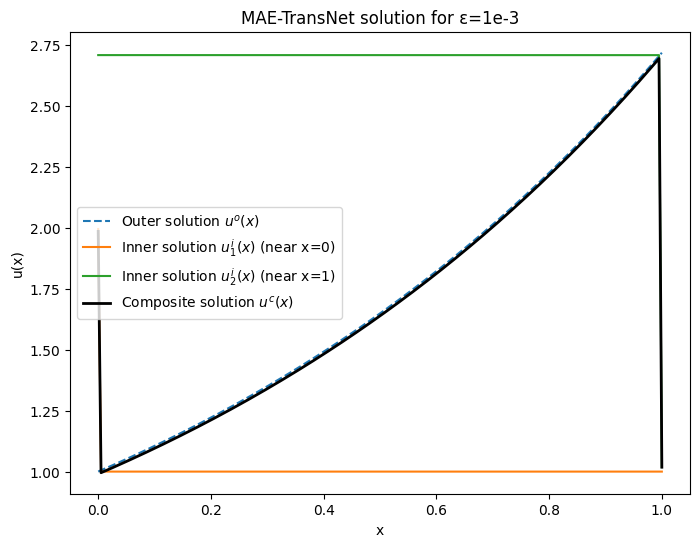

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ==============================
# 定义 TransNet 类
# ==============================
class TransNet(nn.Module):
    def __init__(self, M, d=1, gamma=1.0, nonuniform=False, region=(0,1)):
        super().__init__()
        self.M = M
        self.gamma = gamma
        self.region = region
        # 隐层参数 (a, r)
        if nonuniform:
            # 非均匀分布: 集中在边界层
            self.a = torch.ones(M, d)  # 一维情况 a=1
            self.r = torch.rand(M) * 0.1
        else:
            self.a = torch.ones(M, d)
            self.r = torch.rand(M) * (region[1]-region[0]) + region[0]
        # 输出层参数 (α)
        self.alpha = nn.Parameter(torch.zeros(M+1))  # 包含偏置项

    def forward(self, x):
        features = []
        for m in range(self.M):
            z = self.gamma * (self.a[m,0]*x[:,0] + self.r[m])
            features.append(torch.tanh(z))
        features = torch.stack(features, dim=1)
        out = features @ self.alpha[:-1].unsqueeze(1) + self.alpha[-1]
        return out.squeeze()

# ==============================
# 定义损失函数
# ==============================
def loss_inner1(model, eps, N=200):
    zeta = torch.linspace(0, 1/eps, N).view(-1,1)
    zeta.requires_grad_(True)
    u = model(zeta)
    grads = torch.autograd.grad(u.sum(), zeta, create_graph=True)[0]
    grads2 = torch.autograd.grad(grads.sum(), zeta, create_graph=True)[0]
    pde_res = grads2 - u + 1.0
    bc0 = model(torch.tensor([[0.0]])) - 2.0
    bc1 = model(torch.tensor([[1/eps]])) - np.exp(0.0)
    loss = torch.mean(pde_res**2) + bc0**2 + bc1**2
    return loss

def loss_inner2(model, eps, N=200):
    zeta = torch.linspace(0, 1/eps, N).view(-1,1)
    zeta.requires_grad_(True)
    u = model(zeta)
    grads = torch.autograd.grad(u.sum(), zeta, create_graph=True)[0]
    grads2 = torch.autograd.grad(grads.sum(), zeta, create_graph=True)[0]
    pde_res = grads2 - grads - u + np.e
    bc0 = model(torch.tensor([[0.0]])) - 1.0
    bc1 = model(torch.tensor([[1/eps]])) - np.exp(1.0)
    loss = torch.mean(pde_res**2) + bc0**2 + bc1**2
    return loss

# ==============================
# 训练函数
# ==============================
def train(model, loss_fn, eps, epochs=2000, lr=1e-2):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, eps)
        loss.backward()
        optimizer.step()
    return model

# ==============================
# 主程序
# ==============================
eps = 1e-3

def u_outer(x):
    return np.exp(x)

# 训练内解1
model1 = TransNet(M=20, gamma=1.0, nonuniform=True, region=(0,1/eps))
model1 = train(model1, loss_inner1, eps)

# 训练内解2
model2 = TransNet(M=20, gamma=1.0, nonuniform=True, region=(0,1/eps))
model2 = train(model2, loss_inner2, eps)

# ==============================
# 组合解
# ==============================
x = np.linspace(0,1,200)
x_torch = torch.tensor(x, dtype=torch.float32).view(-1,1)

# 内解1 在原变量下 (x=eps*ζ)
u1_vals = model1(x_torch/eps).detach().numpy()
# 内解2 在原变量下 (ζ=(1-x)/eps)
u2_vals = model2((1-x_torch)/eps).detach().numpy()

uo_vals = u_outer(x)
uo_in1 = u_outer(0.0)
uo_in2 = u_outer(1.0)

uc_vals = uo_vals + u1_vals - uo_in1 + u2_vals - uo_in2

# ==============================
# 绘图
# ==============================
plt.figure(figsize=(8,6))
plt.plot(x, uo_vals, '--', label="Outer solution $u^o(x)$")
plt.plot(x, u1_vals, label="Inner solution $u^i_1(x)$ (near x=0)")
plt.plot(x, u2_vals, label="Inner solution $u^i_2(x)$ (near x=1)")
plt.plot(x, uc_vals, 'k', linewidth=2, label="Composite solution $u^c(x)$")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.title("MAE-TransNet solution for ε=1e-3")
plt.show()


Searching gamma for inner problem 1 ...
inner1: gamma_opt = 7.6898, eta = 8.514767e-29
Searching gamma for inner problem 2 ...
inner2: gamma_opt = 3.82028, eta = 5.007295e-28


/var/folders/42/tjxv8ldx65x5b07fdgrxyw5w0000gn/T/ipykernel_16957/3862629318.py:225: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, u_comp, 'k-', linewidth=2, label=r'Composite $u^c(x)$',color=(0.7, 0.3, 0.5, 0.5))


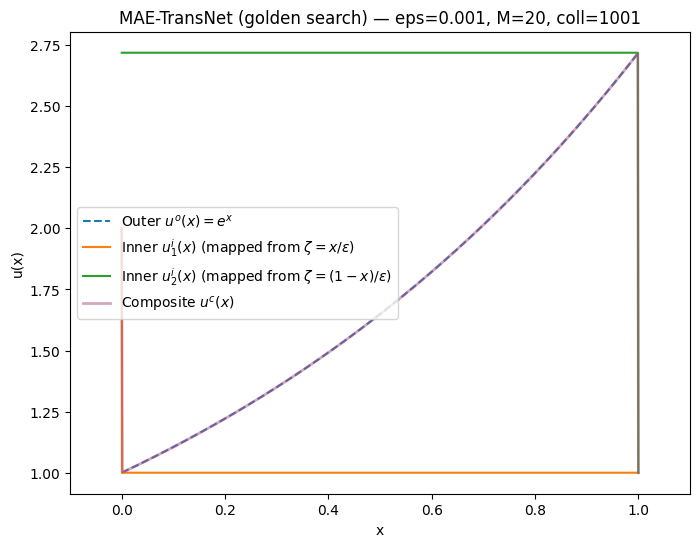

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Problem / parameters
# --------------------------
eps = 1e-3
zeta_max = 1.0 / eps        # scaled domain length (1000)
# TransNet hyperparams
M = 20                      # number of hidden neurons (inner nets)
N_coll = 1001               # interior collocation points for scaled domain
lambda_I = 1.0              # weight for PDE residual
lambda_B = 1.0              # weight for boundary residual
rng = np.random.default_rng(0)

# --------------------------
# Helper: build hidden neurons (1D)
# --------------------------
def build_neurons(M, region_for_r=(0.0, 1.0)):
    # In 1D: a_m is ±1 (unit sphere). Use +1 for simplicity (or random ±1).
    a = rng.choice([-1.0, 1.0], size=M)
    # r_m sampled concentrated in region (for inner net use small region like [0,1])
    r = rng.uniform(region_for_r[0], region_for_r[1], size=M)
    return a, r

# --------------------------
# Basis and derivatives (vectorized)
# For tanh( gamma*(a*zeta + r) )
# phi      = tanh(t)
# phi'     = gamma * a * (1 - tanh^2(t))
# phi''    = -2 * (gamma*a)^2 * tanh(t) * (1 - tanh^2(t))
# --------------------------
def basis_and_derivs(zeta, gamma, a, r):   #计算激活函数及各级导数的值
    # zeta: (Nz,)  a: (M,), r:(M,)
    # produce phi (Nz x M), phi_p, phi_pp
    t = np.outer(zeta, a) * gamma + gamma * r  # (Nz, M)
    tanht = np.tanh(t)
    sech2 = 1.0 - tanht**2
    phi = tanht
    phi_p = (gamma * a) * sech2               # broadcasting works: (M,) -> (Nz,M)
    phi_pp = -2.0 * (gamma * a)**2 * tanht * sech2
    return phi, phi_p, phi_pp

# --------------------------
# Build collocation points (scaled domain)
# --------------------------
zeta_interior = np.linspace(0.0, zeta_max, N_coll)   # inclusive endpoints
zeta_bc = np.array([0.0, zeta_max])                  # two boundary points

# --------------------------
# Operators for two inner BVPs
# inner1: u'' - u = -1, bc: u(0)=2, u(1/eps)=u^o(0)=1
# inner2: u'' - u' - u = -e, bc: u(0)=1, u(1/eps)=u^o(1)=e
# For both, L(1) = -1 (constant).
# --------------------------
L_constant = -1.0

# Right-hand sides:
f1_val = -1.0
f2_val = -np.e

# Boundary values:
uo0 = np.exp(0.0)      # u^o(0) = e^0 = 1
uo1 = np.exp(1.0)      # u^o(1) = e

bc1_vals = np.array([2.0, uo0])   # inner1: u(0)=2, u(1/eps)=1
bc2_vals = np.array([1.0, uo1])   # inner2: u(0)=1, u(1/eps)=e

# --------------------------
# Assemble and solve least squares for given gamma
# Returns residual (eta) and alpha vector (M+1)
# --------------------------
def solve_least_squares_for_gamma(gamma, a, r, problem=1):
    # compute basis and derivatives on interior and boundary points
    phi_int, phi_p_int, phi_pp_int = basis_and_derivs(zeta_interior, gamma, a, r)   # (Ni, M)
    phi_bc, phi_p_bc, phi_pp_bc = basis_and_derivs(zeta_bc, gamma, a, r)           # (2, M)

    if problem == 1:
        # L = d2 - 1
        LPhi_int = phi_pp_int - phi_int   # (Ni, M)
        rhs_int = np.full(zeta_interior.shape, f1_val)
        bc_vals = bc1_vals
    else:
        # problem == 2: L = d2 - d1 - 1
        LPhi_int = phi_pp_int - phi_p_int - phi_int
        rhs_int = np.full(zeta_interior.shape, f2_val)
        bc_vals = bc2_vals

    # Build augmented linear system:
    # Unknown alpha = [alpha_1 ... alpha_M, alpha_0]^T  (alpha_0 is bias)
    # Interior rows: (LPhi_int) @ alpha[:-1] + L(1)*alpha_0 = rhs_int
    Ni = LPhi_int.shape[0]
    A_int = np.hstack([LPhi_int, np.full((Ni,1), L_constant)])   # (Ni, M+1)
    b_int = rhs_int.copy()                                      # (Ni,)

    # Boundary rows: u(zeta_bc) = phi_bc @ alpha[:-1] + 1*alpha_0 = bc_val
    A_bc = np.hstack([phi_bc, np.ones((phi_bc.shape[0],1))])    # (2, M+1)
    b_bc = bc_vals.copy()

    # weight (sqrt of lambda) to combine PDE and BC in one LS problem
    W_int = np.sqrt(lambda_I)
    W_bc = np.sqrt(lambda_B)

    A_stack = np.vstack([W_int * A_int, W_bc * A_bc])   # (Ni+2, M+1)
    b_stack = np.concatenate([W_int * b_int, W_bc * b_bc])

    # solve least squares
    alpha, *_ = np.linalg.lstsq(A_stack, b_stack, rcond=None)
    # compute squared residual
    resid = np.sum((A_stack @ alpha - b_stack)**2)
    return resid, alpha

# --------------------------
# Golden-section search to minimize eta(gamma) over [a,b]
# We'll cache evaluations of eta to avoid recomputation
# --------------------------
phi_g = (np.sqrt(5) - 1) / 2.0

def golden_section_search(a, b, eval_fn, tol=1e-3, maxiter=100):
    # eval_fn: function(gamma) -> (eta, alpha) but we only need eta for min search
    c = b - phi_g * (b - a)
    d = a + phi_g * (b - a)
    cache = {}
    etac, alphac = eval_fn(c)
    etad, alphad = eval_fn(d)
    cache[c] = (etac, alphac)
    cache[d] = (etad, alphad)

    for i in range(maxiter):
        # stop if interval small
        if abs(b - a) < tol:
            break
        if cache[c][0] <= cache[d][0]:
            # move right boundary
            b = d
            d = c
            etad, alphad = cache[d]
            c = b - phi_g * (b - a)
            if c in cache:
                etac, alphac = cache[c]
            else:
                etac, alphac = eval_fn(c)
                cache[c] = (etac, alphac)
        else:
            # move left boundary
            a = c
            c = d
            etac, alphac = cache[c]
            d = a + phi_g * (b - a)
            if d in cache:
                etad, alphad = cache[d]
            else:
                etad, alphad = eval_fn(d)
                cache[d] = (etad, alphad)

    # pick best among cache keys in [a,b]
    keys = [k for k in cache.keys() if a - 1e-12 <= k <= b + 1e-12]
    best_k = min(keys, key=lambda k: cache[k][0])
    return best_k, cache[best_k]   # returns gamma_best, (eta, alpha)

# --------------------------
# Prepare neurons (fix random seed so repeated calls use same neurons)
# --------------------------
a_inner, r_inner = build_neurons(M, region_for_r=(0.0, 1.0))   # concentrated in [0,1]
# we'll use same neurons for both inner problems (paper suggests fixed hidden-layer params)

# --------------------------
# Wrap eval functions for golden search (for problem 1 and 2)
# --------------------------
def eval_gamma_problem1(gamma):
    eta, alpha = solve_least_squares_for_gamma(gamma, a_inner, r_inner, problem=1)
    return eta, alpha

def eval_gamma_problem2(gamma):
    eta, alpha = solve_least_squares_for_gamma(gamma, a_inner, r_inner, problem=2)
    return eta, alpha

# --------------------------
# Run golden-section search for each inner problem
# Choose a reasonable gamma search interval, e.g. [1e-3, 10]
# --------------------------
gamma_min, gamma_max = 1e-3, 10.0
print("Searching gamma for inner problem 1 ...")
gamma1_opt, (eta1_opt, alpha1_opt) = golden_section_search(gamma_min, gamma_max, eval_gamma_problem1,       #这两段是在执行golden search
                                                           tol=1e-3, maxiter=50)
print(f"inner1: gamma_opt = {gamma1_opt:.6g}, eta = {eta1_opt:.6e}")

print("Searching gamma for inner problem 2 ...")
gamma2_opt, (eta2_opt, alpha2_opt) = golden_section_search(gamma_min, gamma_max, eval_gamma_problem2,
                                                           tol=1e-3, maxiter=50)
print(f"inner2: gamma_opt = {gamma2_opt:.6g}, eta = {eta2_opt:.6e}")

# --------------------------
# With gamma_opt and alpha_opt, build predictions on x in [0,1]
# --------------------------
x = np.linspace(0.0, 1.0, 1001)
# evaluate outer solution
u_outer = np.exp(x)

# For inner1: evaluate u1 at zeta = x/eps
zeta_x1 = x / eps
phi1_x, _, _ = basis_and_derivs(zeta_x1, gamma1_opt, a_inner, r_inner)
# alpha vector alpha1_opt has length M+1, last is alpha0
u1_x = phi1_x @ alpha1_opt[:-1] + alpha1_opt[-1]

# For inner2: evaluate u2 at zeta = (1-x)/eps
zeta_x2 = (1.0 - x) / eps
phi2_x, _, _ = basis_and_derivs(zeta_x2, gamma2_opt, a_inner, r_inner)
u2_x = phi2_x @ alpha2_opt[:-1] + alpha2_opt[-1]

# Matching (inner limits of outer solution):
uo_in1 = u_outer[0]   # = e^0 = 1
uo_in2 = u_outer[-1]  # = e^1 = e

# composite solution
u_comp = u_outer + u1_x - uo_in1 + u2_x - uo_in2

# --------------------------
# Plotting
# --------------------------
plt.figure(figsize=(8,6))
plt.plot(x, u_outer, '--', label=r'Outer $u^o(x)=e^x$')
plt.plot(x, u1_x, label=r'Inner $u^i_1(x)$ (mapped from $\zeta=x/\varepsilon$)')
plt.plot(x, u2_x, label=r'Inner $u^i_2(x)$ (mapped from $\zeta=(1-x)/\varepsilon$)')
plt.plot(x, u_comp, 'k-', linewidth=2, label=r'Composite $u^c(x)$',color=(0.7, 0.3, 0.5, 0.5))
plt.xlim(-0.1,1.1)
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title(f'MAE-TransNet (golden search) — eps={eps}, M={M}, coll={N_coll}')
plt.legend()
plt.grid(False)
plt.show()
